In [236]:
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Dense, Input
from keras.utils import plot_model
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [237]:
def preprocess(path): # Function for preprocessing the data
    Data = pd.read_csv(path, header=None)
    columns = [f'feature_{i+1}' for i in range(Data.shape[1])]
    Data.columns = columns
    return Data

In [238]:
test_data = preprocess("/content/drive/MyDrive/Colab Notebooks/CS6910_ASSIGNMENT1/testing_data_set_24.csv")
test_data.shape

(250, 37)

In [239]:
labelled_train_data = preprocess("/content/drive/MyDrive/Colab Notebooks/CS6910_ASSIGNMENT1/training_data_set_24_labeled.csv")
labelled_train_data.shape

(750, 37)

In [240]:
val_data = preprocess("/content/drive/MyDrive/Colab Notebooks/CS6910_ASSIGNMENT1/validation_data_set_24.csv")
val_data.shape

(250, 37)

In [241]:
#labelled_train_data = labelled_train_data.sample(frac = 1)
#val_data = val_data.sample(frac = 1)

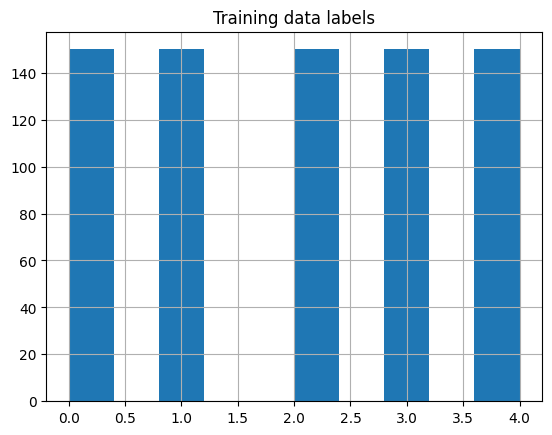

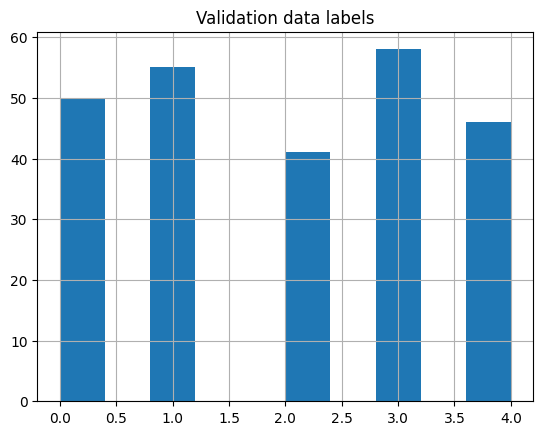

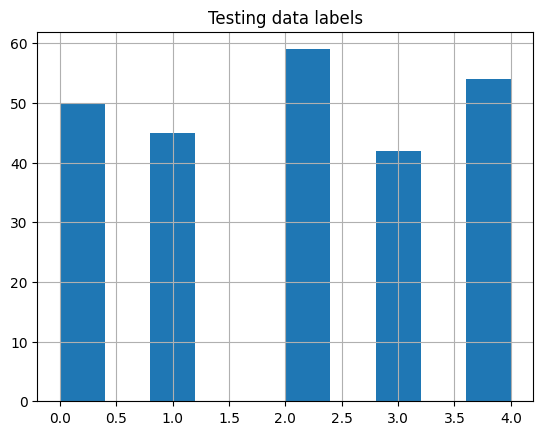

In [242]:
X_train = labelled_train_data.iloc[:,:-1]
Y_train = labelled_train_data.iloc[:,-1]
X_val = val_data.iloc[:,:-1]
Y_val = val_data.iloc[:,-1]
X_test = test_data.iloc[:,:-1]
Y_test = test_data.iloc[:,-1]
Y_train.hist()
plt.title("Training data labels")
plt.show()
print()
Y_val.hist()
plt.title("Validation data labels")
plt.show()
Y_test.hist()
plt.title("Testing data labels")
plt.show()
print()

In [243]:
class AutoEncoder(Model):
    def __init__(self,hidden_dim,bottle_neck_dim,encoder_name):
        super(AutoEncoder, self).__init__()
        """
        Initialize the model parameters
        """
        self.hidden=hidden_dim
        self.bottle_neck=bottle_neck_dim
        self.encoder_name=encoder_name

    def Encoder(self, inputs):
        """
        Functional_parameters
        """
        self.shape=inputs.shape[1]
        x=Dense(units=self.hidden,name=self.encoder_name+'_encoder_h',activation = 'tanh',kernel_initializer='glorot_uniform')(inputs)
        x=Dense(units=self.bottle_neck,name=self.encoder_name+'_bottleneck',kernel_initializer='glorot_uniform')(x)

        return x

    def Decoder(self, inputs):
        x = Dense(units=self.hidden,name=self.encoder_name+'_decoder_h',activation = 'tanh',kernel_initializer='glorot_uniform')(inputs)
        x = Dense(units=self.shape,name=self.encoder_name+'_decoder_out',kernel_initializer='glorot_uniform')(x)

        return x

    def Full_model(self,inputs):
        """
        Full model is required for training
        """
        bottle_neck = self.Encoder(inputs)
        reconstructed = self.Decoder(bottle_neck)

        return reconstructed

In [244]:
AE1_hidden=32
AE1_bottle_neck=28
AE2_hidden=24
AE2_bottle_neck=16
AE3_hidden=12
AE3_bottle_neck=8

Inputs_AE1 = Input(shape=(36,),name = 'Input_AE1')
Inputs_AE2 = Input(shape=(AE1_bottle_neck,),name = 'Input_AE2')
Inputs_AE3 = Input(shape=(AE2_bottle_neck,),name = 'Input_AE3')

AE1=AutoEncoder(AE1_hidden,AE1_bottle_neck,'AE1')
AE2=AutoEncoder(AE2_hidden,AE2_bottle_neck,'AE2')
AE3=AutoEncoder(AE3_hidden,AE3_bottle_neck,'AE3')

outputs_AE1=AE1.Full_model(Inputs_AE1)
Model_AE1 = Model(inputs=Inputs_AE1,outputs=outputs_AE1, name = 'AE1')

outputs_AE2=AE2.Full_model(Inputs_AE2)
Model_AE2 = Model(inputs=Inputs_AE2,outputs=outputs_AE2, name = 'AE2')

outputs_AE3=AE3.Full_model(Inputs_AE3)
Model_AE3 = Model(inputs=Inputs_AE3,outputs=outputs_AE3, name = 'AE3')

In [245]:
Model_AE1.compile(optimizer='Adam',loss='mse')
Model_AE2.compile(optimizer='Adam',loss='mse')
Model_AE3.compile(optimizer='Adam',loss='mse')
input_data = X_train
AEs=[Model_AE1, Model_AE2, Model_AE3]
Encoders = []
batch_size=32
for i,model in enumerate(AEs):
    #print(f"\n Training on {i+1}st AE\n")
    #early_stop = EarlyStopping(monitor = 'loss', mode = 'auto', min_delta = 0.000001, patience = 15, verbose = 0)
    #model.fit(input_data,input_data,verbose=1,batch_size=batch_size,epochs=1000,callbacks=[early_stop])
    Encoder = Model(inputs=model.input,outputs=model.get_layer(f'AE{i+1}_bottleneck').output,name=f'AE_{i+1}')
    #input_data = Encoder.predict(input_data)
    Encoders.append(Encoder)

In [246]:
inputs = Input(shape=(36,),name = 'Input_stacked_AE')
# Stack the encoders
encoded = inputs
for encoder in Encoders:
    encoded = encoder(encoded)

# Create the stacked encoder model
Stacked_encoder_model = Model(inputs=inputs, outputs=encoded, name = 'Stacked_autoencoder')

In [247]:
def plot_learning_curve(history):
    plt.figure(figsize = (10, 8))
    plt.title("Learning curve", fontsize=22)
    plt.plot(history.history['loss'], label = 'Train loss')
    plt.plot(history.history['val_loss'], label = 'Validation loss')
    plt.legend()
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.show()

def Confusion_matrix(y_true,y_pred, data_name):
    labels = np.unique(y_true)
    CM = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (10, 8))
    plt.title(f"Confusion Matrix for {data_name} data", fontsize=18)
    sns.heatmap(CM, annot = True, cmap = 'Pastel2', fmt = 'd', linewidths = 1.0)
    plt.yticks(np.arange(len(labels)) + 0.5, labels, fontsize = 14, rotation = 'horizontal')
    plt.xticks(np.arange(len(labels)) + 0.5, labels, fontsize = 14)
    plt.xlabel("Predicted", fontsize = 16)
    plt.ylabel("Actual", fontsize = 16)
    plt.savefig(f"Conf_{data_name}.png")
    plt.show()

In [248]:
## Define the top layer for domain specific downstream applications
def classification_block(inputs):
    x = Dense(units=12,activation='tanh',name='classifier_dense_1',kernel_initializer='glorot_uniform')(inputs)
    x = Dense(units=5,activation='softmax',name='output_layer',kernel_initializer='glorot_uniform')(x)
    return x

In [249]:
inputs = Input(shape=(36,))
btneck_output = Stacked_encoder_model(inputs)
output = classification_block(btneck_output)
Fine_tunable_model = Model(inputs=inputs,outputs=output)

In [250]:
Fine_tunable_model.compile(optimizer=Adam(learning_rate=0.0001),loss=SparseCategoricalCrossentropy(), metrics=['acc'])
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'auto', min_delta = 0.000001, patience = 15, verbose = 0)
filepath = 'Best_model_epoch_{epoch}_val_loss_{val_loss:.4f}.keras'
chkpt = ModelCheckpoint(filepath = filepath, monitor = 'val_loss', save_best_only = True, verbose = 1)
history_wt = Fine_tunable_model.fit(X_train, Y_train, batch_size = 64, validation_data = (X_val, Y_val), validation_batch_size = 64, epochs = 1000, callbacks = [early_stop, chkpt])

Epoch 1/1000
 1/12 [=>............................] - ETA: 28s - loss: 1.5650 - acc: 0.2344
Epoch 1: val_loss improved from inf to 1.60817, saving model to Best_model_epoch_1_val_loss_1.6082.keras
12/12 [==============================] - 3s 37ms/step - loss: 1.6061 - acc: 0.2293 - val_loss: 1.6082 - val_acc: 0.2480
Epoch 2/1000
12/12 [==============================] - ETA: 0s - loss: 1.5954 - acc: 0.2480
Epoch 2: val_loss improved from 1.60817 to 1.59836, saving model to Best_model_epoch_2_val_loss_1.5984.keras
12/12 [==============================] - 0s 19ms/step - loss: 1.5954 - acc: 0.2480 - val_loss: 1.5984 - val_acc: 0.2600
Epoch 3/1000
 1/12 [=>............................] - ETA: 0s - loss: 1.5909 - acc: 0.2656
Epoch 3: val_loss improved from 1.59836 to 1.58859, saving model to Best_model_epoch_3_val_loss_1.5886.keras
12/12 [==============================] - 0s 16ms/step - loss: 1.5854 - acc: 0.2760 - val_loss: 1.5886 - val_acc: 0.2800
Epoch 4/1000
 1/12 [=>.....................

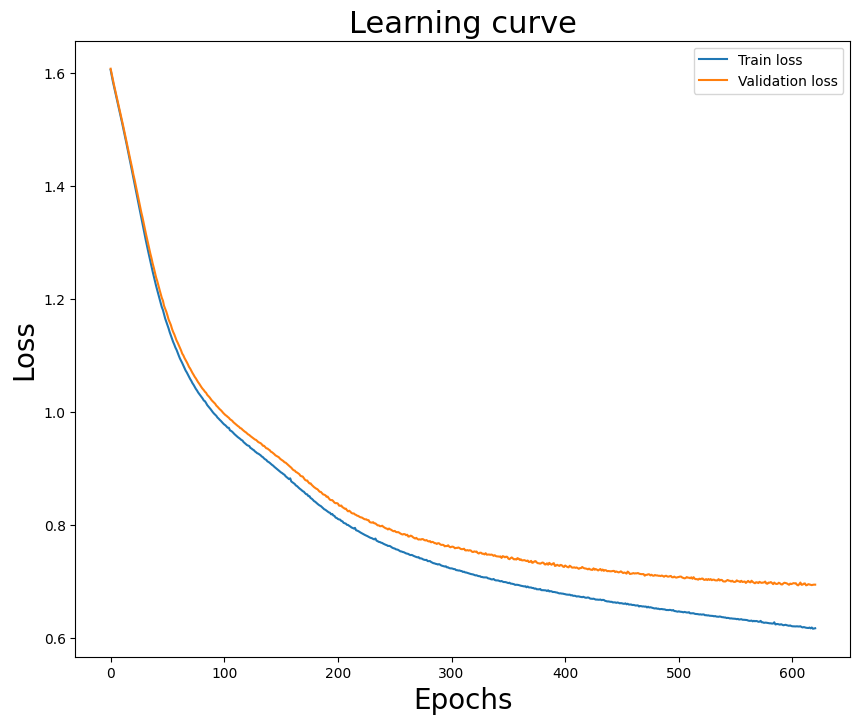

In [251]:
plot_learning_curve(history_wt)

24/24 [==============================] - 0s 2ms/step


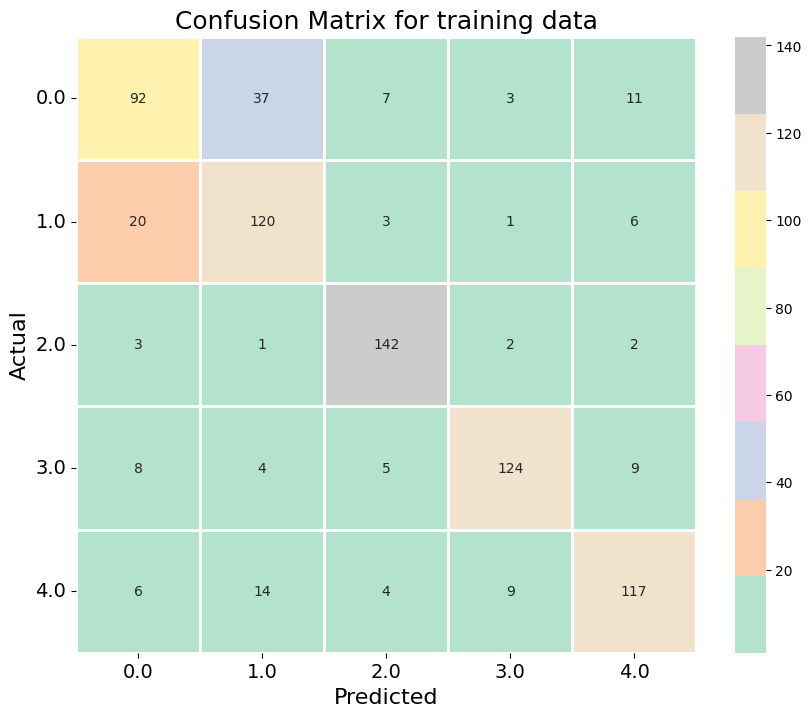

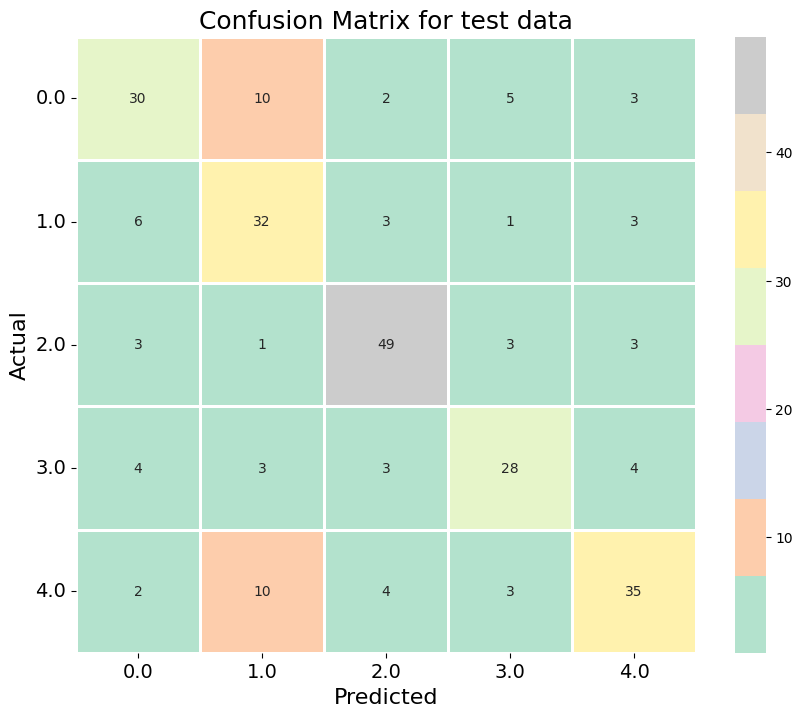

In [252]:
y_pred_test = np.argmax(Fine_tunable_model.predict(X_test),axis=1)
y_pred_train = np.argmax(Fine_tunable_model.predict(X_train),axis=1)

Confusion_matrix(Y_train,y_pred_train, "training")
Confusion_matrix(Y_test,y_pred_test, "test")

In [256]:
from google.colab import files

# Download the file
files.download('Conf_training.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>